In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.colab import files

print("Upload Credit_Card.csv:")
uploaded_features = files.upload()
features_filename = list(uploaded_features.keys())[0]

print("Upload Credit_card_label.csv:")
uploaded_labels = files.upload()
labels_filename = list(uploaded_labels.keys())[0]

Upload Credit_Card.csv:


Saving Credit_card.csv to Credit_card (2).csv
Upload Credit_card_label.csv:


Saving Credit_card_label.csv to Credit_card_label (2).csv


In [72]:
features_df = pd.read_csv(features_filename)
labels_df = pd.read_csv(labels_filename)

print("=== DATA DEBUG INFO ===")
print(f"Features shape: {features_df.shape}")
print(f"Labels shape: {labels_df.shape}")
print("Features columns:", features_df.columns.tolist())
print("Labels columns:", labels_df.columns.tolist())

# Merge features and labels on Ind_ID (common key)
df = pd.merge(features_df, labels_df, on='Ind_ID')
print(f"Merged data shape: {df.shape}")

# Drop the ID column as it's not useful for prediction
df = df.drop(columns=['Ind_ID'])


print(f"Target distribution: {df['label'].value_counts()}")

print("\n=== PREPROCESSING CATEGORICAL COLUMNS ===")

categorical_columns = df.select_dtypes(include=['object']).columns
print(f"Categorical columns: {list(categorical_columns)}")

for col in categorical_columns:
    if col != 'label':
        unique_vals = df[col].unique()
        print(f"Column '{col}': {unique_vals}")
        print(f"NaN count in '{col}': {df[col].isnull().sum()}")

binary_mappings = {
    'GENDER': {'M': 1, 'F': 0, 'Male': 1, 'Female': 0},
    'Car_Owner': {'Y': 1, 'N': 0, 'Yes': 1, 'No': 0},
    'Propert_Owner': {'Y': 1, 'N': 0, 'Yes': 1, 'No': 0}
    # Mobile_phone, Work_phone, Phone, EMAIL_ID are already 1/0
}

for col, mapping in binary_mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)
        print(f"Converted {col} using mapping: {mapping}")

# Handle NaN values in the categorical columns
for col in binary_mappings.keys():
    if col in df.columns:
        nan_count = df[col].isnull().sum()
        if nan_count > 0:
            # Fill NaN with the most frequent value (mode)
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
            print(f"Filled {nan_count} NaN values in {col} with mode: {mode_val}")

# Handle the other categorical columns with NaNs
categorical_with_nans = ['Type_Occupation', 'Housing_type', 'Marital_status', 'EDUCATION', 'Type_Income']

for col in categorical_with_nans:
    if col in df.columns:
        nan_count = df[col].isnull().sum()
        if nan_count > 0:
            # Fill NaN with 'Missing' category
            df[col] = df[col].fillna('Missing')
            print(f"Filled {nan_count} NaN values in {col} with 'Missing'")

# Handle missing values in numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col != 'label']

for col in numeric_columns:
    nan_count = df[col].isnull().sum()
    if nan_count > 0:
        # Fill numeric NaN with median
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled {nan_count} NaN values in {col} with median: {median_val}")

print(f"Total missing values after all processing: {df.isnull().sum().sum()}")

# If there are still any missing values, drop those rows
if df.isnull().sum().sum() > 0:
    df = df.dropna()
    print(f"Data shape after dropping remaining NA: {df.shape}")

# Identify target column
target_col = 'label'
print(f"Target column: {target_col}")

# Prepare features and target
X = df.drop(columns=[target_col])
y = df[target_col].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Convert remaining categorical variables to dummy variables
remaining_categorical = X.select_dtypes(include=['object']).columns
print(f"Remaining categorical columns for one-hot encoding: {list(remaining_categorical)}")

if len(remaining_categorical) > 0:
    X = pd.get_dummies(X, columns=remaining_categorical, drop_first=True)
    print(f"Features shape after one-hot encoding: {X.shape}")


X = X.astype(float)

# Check for any infinite or NaN values in features
print(f"NaN in features: {np.isnan(X.values).any()}")
print(f"Inf in features: {np.isinf(X.values).any()}")

# Check data types of all features
print(f"Feature data types:\n{X.dtypes}")

# Identify binary columns (0/1) to exclude from scaling
binary_columns = []
for col in X.columns:
    unique_vals = X[col].unique()
    if set(unique_vals).issubset({0, 1}) and len(unique_vals) <= 2:
        binary_columns.append(col)

print(f"Binary columns (won't scale): {len(binary_columns)}")
print(f"Total binary columns: {len(binary_columns)}")

# Feature scaling - only scale non-binary columns
scaler = StandardScaler()
continuous_cols = [col for col in X.columns if col not in binary_columns]
print(f"Continuous columns to scale: {len(continuous_cols)}")

if continuous_cols:
    X_continuous_scaled = scaler.fit_transform(X[continuous_cols])
    # Combine scaled continuous with unscaled binary
    X_scaled = np.column_stack([X_continuous_scaled, X[binary_columns].values])
    # Recreate feature names in correct order
    feature_names = continuous_cols + binary_columns
else:
    # All columns are binary, no scaling needed
    X_scaled = X.values
    feature_names = list(X.columns)

# Add bias column
X_with_bias = np.column_stack([np.ones(len(X_scaled)), X_scaled])

print(f"Final data shape: {X_with_bias.shape}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Number of features: {len(feature_names)}")
print(f"Sample feature names: {feature_names[:5]}...")  # Show first 5 to avoid too much output

=== DATA DEBUG INFO ===
Features shape: (1548, 18)
Labels shape: (1548, 2)
Features columns: ['Ind_ID', 'GENDER', 'Car_Owner', 'Propert_Owner', 'CHILDREN', 'Annual_income', 'Type_Income', 'EDUCATION', 'Marital_status', 'Housing_type', 'Birthday_count', 'Employed_days', 'Mobile_phone', 'Work_Phone', 'Phone', 'EMAIL_ID', 'Type_Occupation', 'Family_Members']
Labels columns: ['Ind_ID', 'label']
Merged data shape: (1548, 19)
Target distribution: label
0    1373
1     175
Name: count, dtype: int64

=== PREPROCESSING CATEGORICAL COLUMNS ===
Categorical columns: ['GENDER', 'Car_Owner', 'Propert_Owner', 'Type_Income', 'EDUCATION', 'Marital_status', 'Housing_type', 'Type_Occupation']
Column 'GENDER': ['M' 'F' nan]
NaN count in 'GENDER': 7
Column 'Car_Owner': ['Y' 'N']
NaN count in 'Car_Owner': 0
Column 'Propert_Owner': ['Y' 'N']
NaN count in 'Propert_Owner': 0
Column 'Type_Income': ['Pensioner' 'Commercial associate' 'Working' 'State servant']
NaN count in 'Type_Income': 0
Column 'EDUCATION': ['

In [73]:
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

def predict_proba(X, w):
    return sigmoid(X @ w)

def binary_cross_entropy(y_true, y_prob, eps=1e-12):
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

def gradient(X, y_true, y_prob):
    return (X.T @ (y_prob - y_true)) / len(y_true)

In [74]:
w_initial = np.zeros(X_with_bias.shape[1])

learning_rate = 0.07
num_iterations = 250

# Print starting statistics
print("STARTING STATISTICS:")
print(f"Starting parameters shape: {w_initial.shape}")
print(f"Learning rate: {learning_rate}, Iterations: {num_iterations}")

y_prob_initial = predict_proba(X_with_bias, w_initial)
initial_cost = binary_cross_entropy(y, y_prob_initial)
print(f"Starting cost: {initial_cost:.6f}")
print(f"Number of features: {len(feature_names)}")

STARTING STATISTICS:
Starting parameters shape: (47,)
Learning rate: 0.07, Iterations: 250
Starting cost: 0.693147
Number of features: 46


In [75]:
w = w_initial.copy()
cost_history = []
w_history = []

print("Training...")
for i in range(num_iterations):
    y_prob = predict_proba(X_with_bias, w)
    cost = binary_cross_entropy(y, y_prob)
    cost_history.append(cost)

    # Store weights at quarter points
    if i in [0, num_iterations//4, num_iterations//2, 3*num_iterations//4]:
        w_history.append((i, w.copy()))

    grad = gradient(X_with_bias, y, y_prob)
    w = w - learning_rate * grad

# Store final weights
w_final = w.copy()
final_cost = cost_history[-1]
w_history.append((num_iterations, w_final))


print("Training completed!")

Training...
Training completed!


In [76]:
print("\n=== FINAL STATISTICS ===")
print(f"Final parameters: {w_final}")
print(f"Final cost: {final_cost:.6f}")


=== FINAL STATISTICS ===
Final parameters: [-0.43335399 -0.02006528  0.05954521 -0.12232081  0.02149031  0.01202142
  0.01523718 -0.12667014 -0.23445905 -0.43335399 -0.0603851  -0.09057175
 -0.01332598 -0.00172183 -0.12334553 -0.24615338 -0.09047221 -0.06208843
  0.03036706 -0.30778578 -0.22675765 -0.01638515 -0.0091686  -0.04795475
 -0.41695034  0.06172621  0.00367654  0.00482181 -0.09815097 -0.01087777
  0.0131549  -0.01716176 -0.01875594 -0.00506985 -0.02213849  0.02020399
 -0.06179048  0.0091013  -0.05554027 -0.04381997 -0.15029031 -0.0267557
 -0.00328772 -0.08006538 -0.01467268  0.04899058  0.00306418]
Final cost: 0.345914


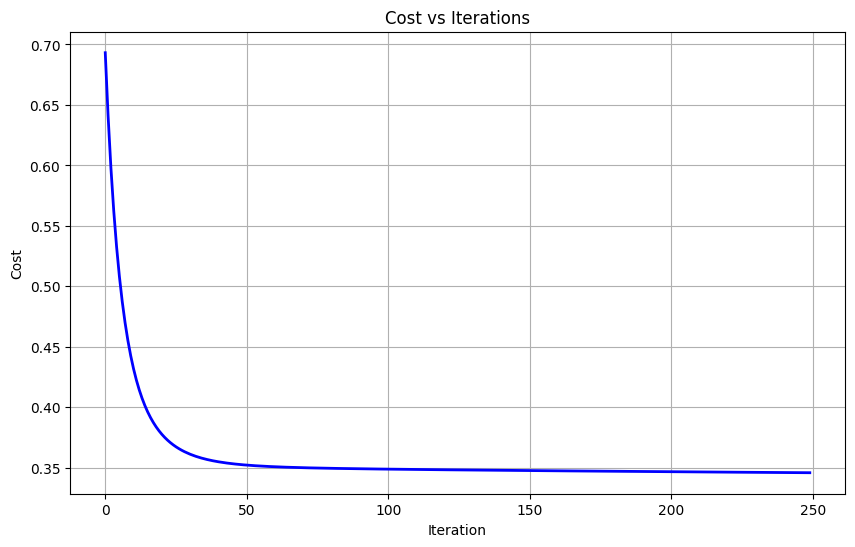

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(cost_history, 'b-', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost vs Iterations")
plt.grid(True)
plt.show()

Top 3 parameters: ['Work_Phone', 'Housing_type_House / apartment', 'EDUCATION_Secondary / secondary special']


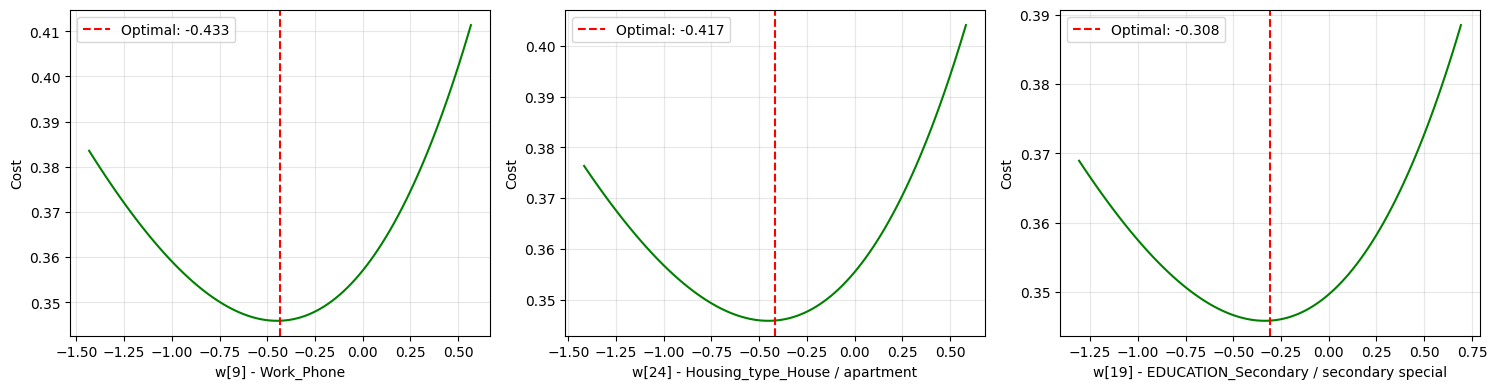

In [78]:
param_indices = np.argsort(np.abs(w_final[1:]))[::-1][:3] + 1
feature_names = list(X.columns)

print(f"Top 3 parameters: {[feature_names[i-1] for i in param_indices]}")

plt.figure(figsize=(15, 4))
for idx, param_idx in enumerate(param_indices):
    plt.subplot(1, 3, idx+1)

    center = w_final[param_idx]
    sweep = np.linspace(center-1.0, center+1.0, 100)
    costs = []

    for val in sweep:
        w_tmp = w_final.copy()
        w_tmp[param_idx] = val
        y_prob_tmp = predict_proba(X_with_bias, w_tmp)
        costs.append(binary_cross_entropy(y, y_prob_tmp))

    plt.plot(sweep, costs, 'g-')
    plt.axvline(center, color='r', linestyle='--', label=f'Optimal: {center:.3f}')
    plt.xlabel(f'w[{param_idx}] - {feature_names[param_idx-1]}')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Top 3 parameters: ['Work_Phone', 'Housing_type_House / apartment', 'EDUCATION_Secondary / secondary special']


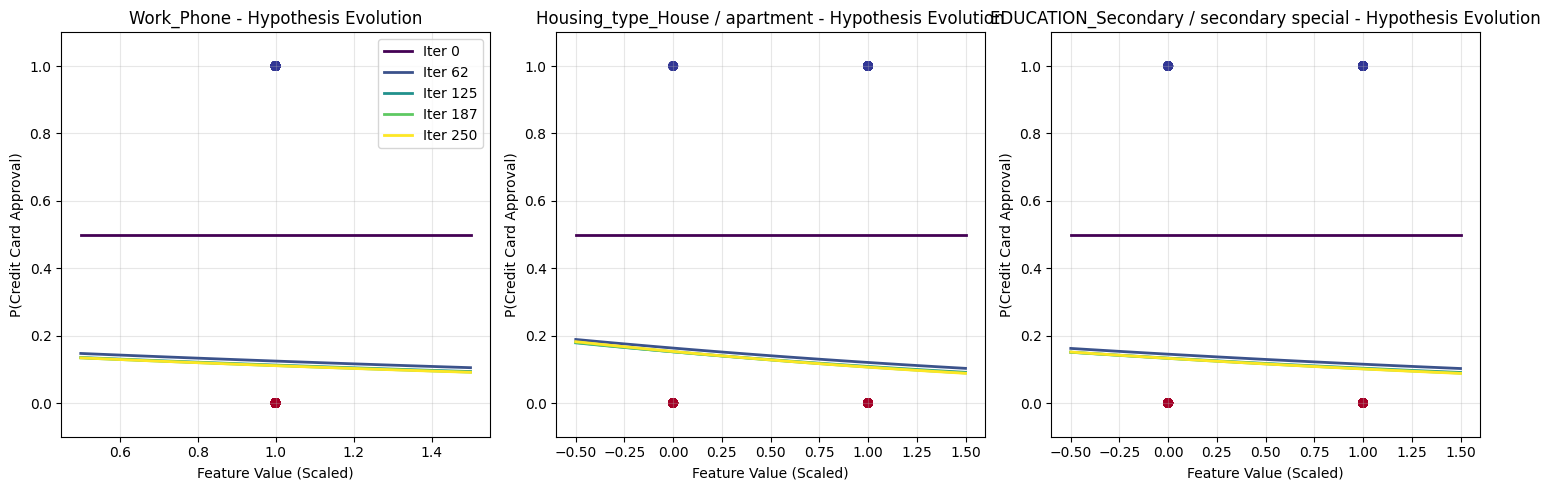

In [79]:
param_indices = np.argsort(np.abs(w_final[1:]))[::-1][:3] + 1
feature_names = list(X.columns)

print(f"Top 3 parameters: {[feature_names[i-1] for i in param_indices]}")

# Create one graph per feature showing evolution through all iterations
plt.figure(figsize=(15, 5))

# Color map for different iterations
colors = plt.cm.viridis(np.linspace(0, 1, len(w_history)))

for param_idx, (param_index, param_name) in enumerate(zip(param_indices, [feature_names[i-1] for i in param_indices])):
    plt.subplot(1, 3, param_idx + 1)

    # Create range for this feature
    x_range = np.linspace(X_scaled[:, param_index-1].min()-0.5,
                         X_scaled[:, param_index-1].max()+0.5, 100)

    # Plot each iteration
    for idx, (iter_num, w_current) in enumerate(w_history):
        # Create feature matrix: set all features to their mean except the current parameter
        X_test = np.full((100, X_scaled.shape[1]), X_scaled.mean(axis=0))
        X_test[:, param_index-1] = x_range

        # Add bias and predict
        X_test_with_bias = np.column_stack([np.ones(100), X_test])
        y_probs = predict_proba(X_test_with_bias, w_current)

        # Plot with color coding by iteration
        plt.plot(x_range, y_probs, color=colors[idx], linewidth=2,
                label=f'Iter {iter_num}' if param_idx == 0 else "")

    # Add data points
    plt.scatter(X_scaled[:, param_index-1], y, alpha=0.3, c=y, cmap='RdYlBu')
    plt.title(f'{param_name} - Hypothesis Evolution')
    plt.xlabel('Feature Value (Scaled)')
    plt.ylabel('P(Credit Card Approval)')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.3)

    # Add legend only to first subplot
    if param_idx == 0:
        plt.legend()

plt.tight_layout()
plt.show()

Top 3 parameters: ['Work_Phone', 'Housing_type_House / apartment', 'EDUCATION_Secondary / secondary special']


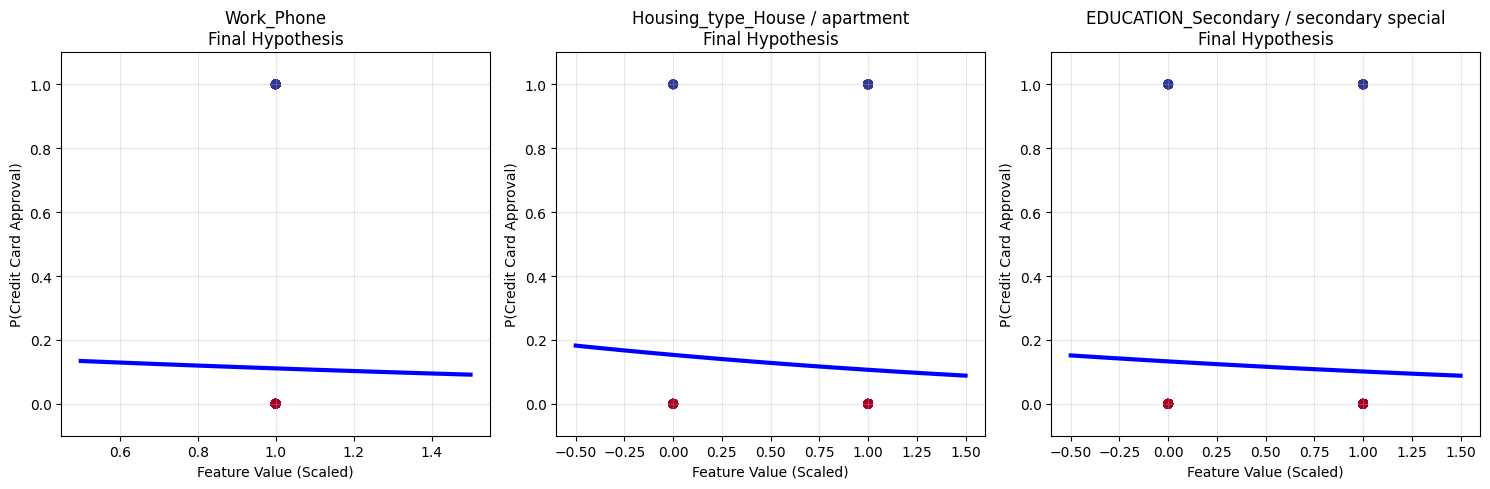

In [80]:
param_indices = np.argsort(np.abs(w_final[1:]))[::-1][:3] + 1
feature_names = list(X.columns)

print(f"Top 3 parameters: {[feature_names[i-1] for i in param_indices]}")

# Create one graph per feature showing final hypothesis
plt.figure(figsize=(15, 5))

for param_idx, (param_index, param_name) in enumerate(zip(param_indices, [feature_names[i-1] for i in param_indices])):
    plt.subplot(1, 3, param_idx + 1)

    # Create range for this feature
    x_range = np.linspace(X_scaled[:, param_index-1].min()-0.5,
                         X_scaled[:, param_index-1].max()+0.5, 100)

    # Create feature matrix: set all features to their mean except the current parameter
    X_test = np.full((100, X_scaled.shape[1]), X_scaled.mean(axis=0))
    X_test[:, param_index-1] = x_range

    # Add bias and predict
    X_test_with_bias = np.column_stack([np.ones(100), X_test])
    y_probs = predict_proba(X_test_with_bias, w_final)

    # Plot final hypothesis
    plt.plot(x_range, y_probs, 'b-', linewidth=3, label='Final Hypothesis')

    # Add data points
    plt.scatter(X_scaled[:, param_index-1], y, alpha=0.3, c=y, cmap='RdYlBu')
    plt.title(f'{param_name}\nFinal Hypothesis')
    plt.xlabel('Feature Value (Scaled)')
    plt.ylabel('P(Credit Card Approval)')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()